In [49]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [50]:
# Upload de dados
from google.colab import files
uploaded = files.upload()

Saving caminhando.csv to caminhando.csv
Saving correndo.csv to correndo.csv
Saving parado.csv to parado.csv
Saving pulando.csv to pulando.csv


In [51]:
#Configuração inicial de features
# ==================== CONFIGURAÇÃO ====================
WINDOW_SIZE = 20
STRIDE = 10

# ==================== FUNÇÕES ====================
def create_windows(data, labels, window_size, stride):
    windows = []
    window_labels = []

    for label in np.unique(labels):
        class_data = data[labels == label]
        for i in range(0, len(class_data) - window_size + 1, stride):
            window = class_data[i:i + window_size]
            windows.append(window)
            window_labels.append(label)

    return np.array(windows), np.array(window_labels)

def extract_movement_features(windows):
    """
    Extrai features que capturam MOVIMENTO

    Features:
    1. Desvio padrão (variabilidade) - ax, ay, az, gx, gy, gz (6)
    2. Magnitude média do acelerômetro (1)
    3. Magnitude média do giroscópio (1)
    4. Range - ax, ay, az (3)
    5. Zero-crossing rate - ax, ay, az (3)

    Total: 14 features
    """
    n_windows = windows.shape[0]
    features = np.zeros((n_windows, 14))

    for i in range(n_windows):
        window = windows[i]

        # 1. Desvio padrão (captura variação/movimento)
        features[i, 0] = np.std(window[:, 0])  # std_ax
        features[i, 1] = np.std(window[:, 1])  # std_ay
        features[i, 2] = np.std(window[:, 2])  # std_az
        features[i, 3] = np.std(window[:, 3])  # std_gx
        features[i, 4] = np.std(window[:, 4])  # std_gy
        features[i, 5] = np.std(window[:, 5])  # std_gz

        # 2. Magnitude média (intensidade total)
        accel_mag = np.sqrt(window[:, 0]**2 + window[:, 1]**2 + window[:, 2]**2)
        gyro_mag = np.sqrt(window[:, 3]**2 + window[:, 4]**2 + window[:, 5]**2)
        features[i, 6] = np.mean(accel_mag)
        features[i, 7] = np.mean(gyro_mag)

        # 3. Range (pico-a-pico) - diferença entre max e min
        features[i, 8] = np.max(window[:, 0]) - np.min(window[:, 0])  # range_ax
        features[i, 9] = np.max(window[:, 1]) - np.min(window[:, 1])  # range_ay
        features[i, 10] = np.max(window[:, 2]) - np.min(window[:, 2]) # range_az

        # 4. Zero-crossing rate (quantas vezes cruza a média)
        mean_ax = np.mean(window[:, 0])
        mean_ay = np.mean(window[:, 1])
        mean_az = np.mean(window[:, 2])

        zcr_ax = np.sum(np.abs(np.diff(np.sign(window[:, 0] - mean_ax)))) / 2
        zcr_ay = np.sum(np.abs(np.diff(np.sign(window[:, 1] - mean_ay)))) / 2
        zcr_az = np.sum(np.abs(np.diff(np.sign(window[:, 2] - mean_az)))) / 2

        features[i, 11] = zcr_ax
        features[i, 12] = zcr_ay
        features[i, 13] = zcr_az

    return features

In [52]:
#Carregar dados com pandas
print("\n" + "="*70)
print("CARREGANDO DADOS")
print("="*70)

datasets = {}
for filename in ['parado.csv', 'caminhando.csv', 'correndo.csv', 'pulando.csv']:
    label = filename.replace('.csv', '')
    df = pd.read_csv(filename, header=None,
                     names=['ax', 'ay', 'az', 'gx', 'gy', 'gz'])
    datasets[label] = df
    print(f"{label:12s}: {len(df):4d} amostras")

all_data = []
all_labels = []

for label, df in datasets.items():
    all_data.append(df.values)
    all_labels.extend([label] * len(df))

X_raw = np.vstack(all_data)
y_raw = np.array(all_labels)


CARREGANDO DADOS
parado      : 1379 amostras
caminhando  : 1098 amostras
correndo    : 1204 amostras
pulando     :  912 amostras


In [53]:
#Criando janelas
#JANELAS
print("\n" + "="*70)
print("CRIANDO JANELAS")
print("="*70)

X_windows, y_windows = create_windows(X_raw, y_raw, WINDOW_SIZE, STRIDE)
print(f"Janelas: {len(X_windows)}")


CRIANDO JANELAS
Janelas: 453



EXTRAINDO FEATURES DE MOVIMENTO
Features: (453, 14) (14 features por janela)

Features médias por classe (as que mais importam para movimento):

Classe         std_ax   std_ay   std_az  mag_accel  range_ax
----------------------------------------------------------------------
parado            146      165      172      16590       563
caminhando        909      812     1045      16397      3298
correndo         3508     3182     3866      17665     13361
pulando          3538     2877    12275      15302     13536


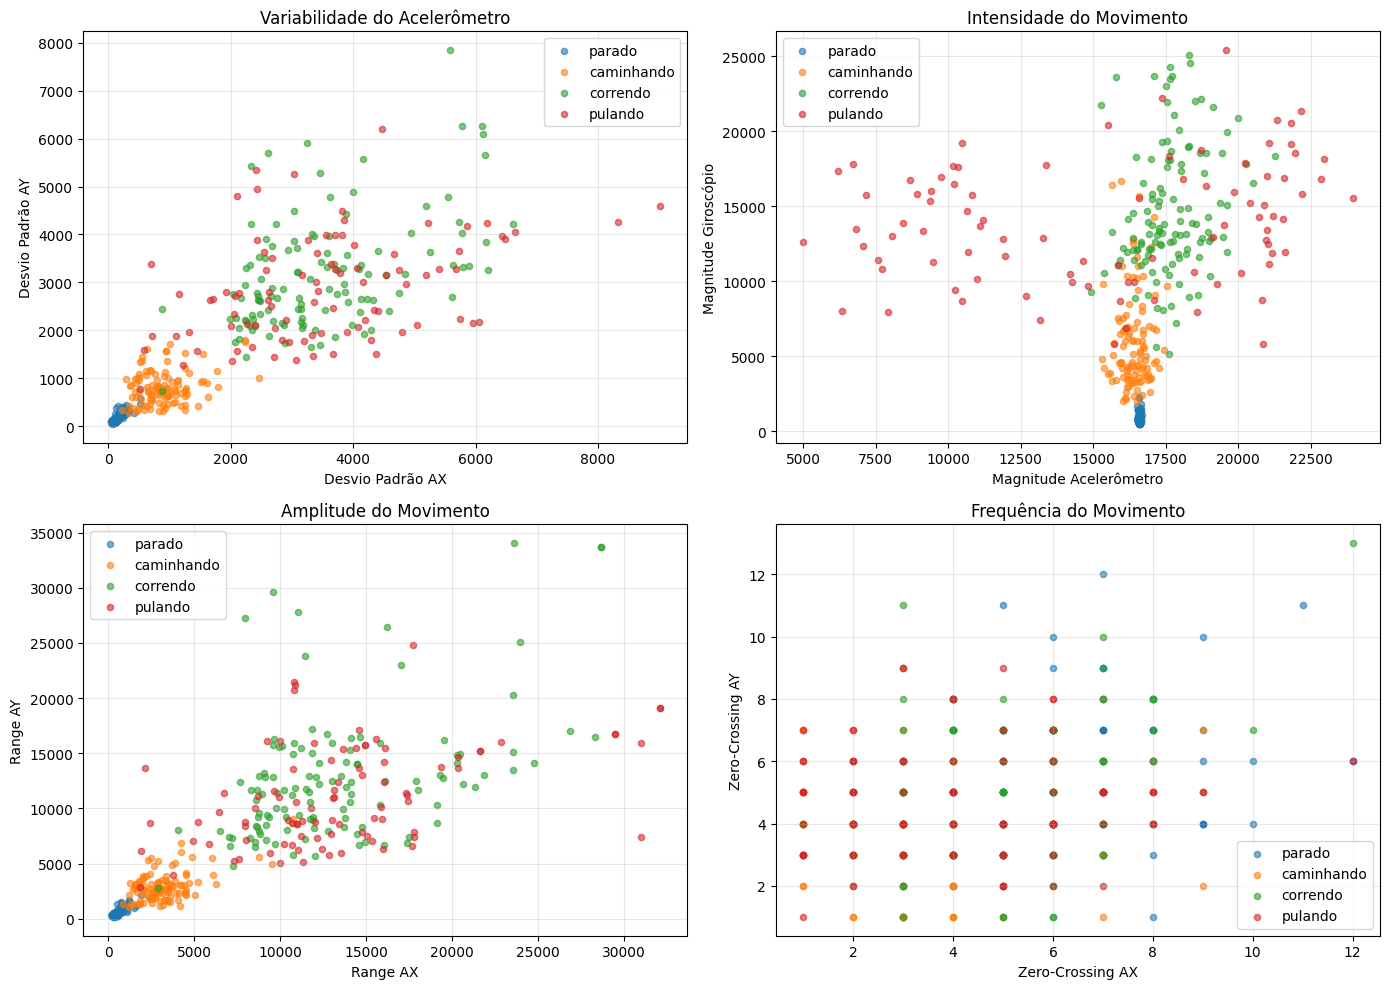

In [54]:
#EXTRAINDO FEATURES
print("\n" + "="*70)
print("EXTRAINDO FEATURES DE MOVIMENTO")
print("="*70)

X_features = extract_movement_features(X_windows)
print(f"Features: {X_features.shape} (14 features por janela)")

# Mostrar features por classe
feature_names = [
    'std_ax', 'std_ay', 'std_az', 'std_gx', 'std_gy', 'std_gz',
    'mag_accel', 'mag_gyro',
    'range_ax', 'range_ay', 'range_az',
    'zcr_ax', 'zcr_ay', 'zcr_az'
]

activities = ['parado', 'caminhando', 'correndo', 'pulando']

print("\nFeatures médias por classe (as que mais importam para movimento):")
print(f"\n{'Classe':<12} {'std_ax':>8} {'std_ay':>8} {'std_az':>8} {'mag_accel':>10} {'range_ax':>9}")
print("-" * 70)

for activity in activities:
    idx = y_windows == activity
    features = X_features[idx]

    print(f"{activity:<12} ", end="")
    print(f"{np.mean(features[:, 0]):>8.0f} ", end="")  # std_ax
    print(f"{np.mean(features[:, 1]):>8.0f} ", end="")  # std_ay
    print(f"{np.mean(features[:, 2]):>8.0f} ", end="")  # std_az
    print(f"{np.mean(features[:, 6]):>10.0f} ", end="") # mag_accel
    print(f"{np.mean(features[:, 8]):>9.0f}")           # range_ax

# Visualizar separação de features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Desvio padrão acelerômetro
ax = axes[0, 0]
for activity in activities:
    idx = y_windows == activity
    ax.scatter(X_features[idx, 0], X_features[idx, 1],
              label=activity, alpha=0.6, s=20)
ax.set_xlabel('Desvio Padrão AX')
ax.set_ylabel('Desvio Padrão AY')
ax.set_title('Variabilidade do Acelerômetro')
ax.legend()
ax.grid(True, alpha=0.3)

# Magnitude
ax = axes[0, 1]
for activity in activities:
    idx = y_windows == activity
    ax.scatter(X_features[idx, 6], X_features[idx, 7],
              label=activity, alpha=0.6, s=20)
ax.set_xlabel('Magnitude Acelerômetro')
ax.set_ylabel('Magnitude Giroscópio')
ax.set_title('Intensidade do Movimento')
ax.legend()
ax.grid(True, alpha=0.3)

# Range
ax = axes[1, 0]
for activity in activities:
    idx = y_windows == activity
    ax.scatter(X_features[idx, 8], X_features[idx, 9],
              label=activity, alpha=0.6, s=20)
ax.set_xlabel('Range AX')
ax.set_ylabel('Range AY')
ax.set_title('Amplitude do Movimento')
ax.legend()
ax.grid(True, alpha=0.3)

# Zero-crossing
ax = axes[1, 1]
for activity in activities:
    idx = y_windows == activity
    ax.scatter(X_features[idx, 11], X_features[idx, 12],
              label=activity, alpha=0.6, s=20)
ax.set_xlabel('Zero-Crossing AX')
ax.set_ylabel('Zero-Crossing AY')
ax.set_title('Frequência do Movimento')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('features_movimento.png', dpi=150, bbox_inches='tight')
plt.show()

In [55]:
#PREPARAR DADOS PARA TREINAR
print("\n" + "="*70)
print("PREPARANDO TREINAMENTO")
print("="*70)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_features, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Treino: {len(X_train)}, Validação: {len(X_val)}, Teste: {len(X_test)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


PREPARANDO TREINAMENTO
Treino: 317, Validação: 68, Teste: 68


In [56]:
#CONSTRUIR MODELO
print("\n" + "="*70)
print("CONSTRUINDO MODELO")
print("="*70)

model = keras.Sequential([
    layers.Input(shape=(14,)),  # 14 features agora!
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ==================== TREINAR ====================
print("\n" + "="*70)
print("TREINAMENTO")
print("="*70)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        )
    ]
)



CONSTRUINDO MODELO


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,076 (4.20 KB)

 Trainable params: 1,076 (4.20 KB)

 Non-trainable params: 0 (0.00 B)


TREINAMENTO
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.2081 - loss: 1.4945 - val_accuracy: 0.2794 - val_loss: 1.3226
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4026 - loss: 1.2615 - val_accuracy: 0.4706 - val_loss: 1.1358
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5256 - loss: 1.1024 - val_accuracy: 0.6324 - val_loss: 0.9825
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5972 - loss: 1.0224 - val_accuracy: 0.7059 - val_loss: 0.8629
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5914 - loss: 0.9384 - val_accuracy: 0.7647 - val_loss: 0.7668
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6178 - loss: 0.9563 - val_accuracy: 0.7794 - val_loss: 0.6887
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6881 - loss: 0.8230 - val_accuracy: 0.7941 - val_loss: 0.6218
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7385 - loss: 0.7202 - val


RESULTADOS
Acurácia: 98.53%

              precision    recall  f1-score   support

  caminhando       1.00      0.94      0.97        16
    correndo       0.95      1.00      0.97        18
      parado       1.00      1.00      1.00        21
     pulando       1.00      1.00      1.00        13

    accuracy                           0.99        68
   macro avg       0.99      0.98      0.99        68
weighted avg       0.99      0.99      0.99        68



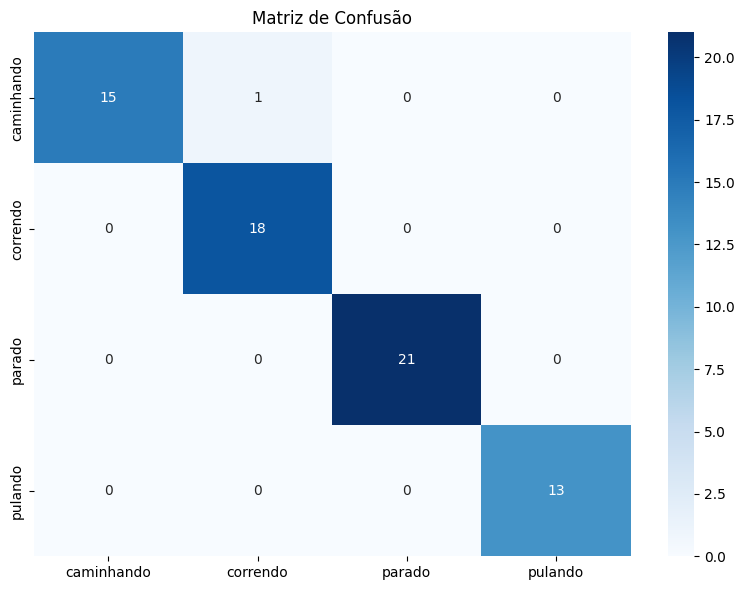

In [57]:
#AVALIAR MODELO
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\n{'='*70}")
print("RESULTADOS")
print("="*70)
print(f"Acurácia: {test_accuracy*100:.2f}%")

y_pred = model.predict(X_test_scaled, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

print(f"\n{classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.savefig('matriz_confusao.png', dpi=150)
plt.show()

In [58]:
#CONVERTER TFLITE
print("\n" + "="*70)
print("CONVERSÃO TFLITE")
print("="*70)

def representative_dataset():
    for i in range(min(100, len(X_train_scaled))):
        yield [X_train_scaled[i:i+1].astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print(f"✓ TFLite: {len(tflite_model)/1024:.2f} KB")


CONVERSÃO TFLITE
Saved artifact at '/tmp/tmp3tr_e_jn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 14), dtype=tf.float32, name='keras_tensor_23')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136716208582160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136716208583696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136716208570832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136716208572368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136716565522832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136716208570448: TensorSpec(shape=(), dtype=tf.resource, name=None)
✓ TFLite: 4.86 KB


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [59]:
#GERANDO MODEL.H
print("\n" + "="*70)
print("GERANDO MODEL.H")
print("="*70)

def convert_to_c_array(data):
    hex_array = []
    for i, byte in enumerate(data):
        if i % 12 == 0:
            hex_array.append('\n  ')
        hex_array.append(f'0x{byte:02x}, ')
    return ''.join(hex_array)

c_code = f"""// Modelo TinyML - Features de Movimento
// Acurácia: {test_accuracy*100:.2f}%

#ifndef MODEL_H
#define MODEL_H

const unsigned char model_data[] = {{{convert_to_c_array(tflite_model)}
}};

const unsigned int model_data_len = {len(tflite_model)};

#endif
"""

with open('model.h', 'w') as f:
    f.write(c_code)

print("✓ model.h criado")


GERANDO MODEL.H
✓ model.h criado


In [60]:
#PARÂMETROS DO FIRMWARE
print("\n" + "="*70)
print("PARÂMETROS PARA O FIRMWARE")
print("="*70)
print("\nCOPIE ESTES VALORES:\n")

print("// Normalização (14 features)")
print("const float scaler_mean[14] = {")
for i in range(14):
    print(f"    {scaler.mean_[i]:.4f}f{',' if i < 13 else ''}")
print("};\n")

print("const float scaler_scale[14] = {")
for i in range(14):
    print(f"    {scaler.scale_[i]:.4f}f{',' if i < 13 else ''}")
print("};\n")

print("const char* class_names[4] = {")
for i, label in enumerate(label_encoder.classes_):
    print(f'    "{label}"{',' if i < 3 else ''}')
print("};")

print("\n" + "="*70)
print("NOMES DAS FEATURES")
print("="*70)
for i, name in enumerate(feature_names):
    print(f"  [{i:2d}] {name}")


PARÂMETROS PARA O FIRMWARE

COPIE ESTES VALORES:

// Normalização (14 features)
const float scaler_mean[14] = {
    1934.8329f,
    1674.6427f,
    3704.0657f,
    3830.9411f,
    4841.4041f,
    3924.0823f,
    16553.6141f,
    8511.7087f,
    7386.9779f,
    6556.6814f,
    11602.0662f,
    4.7035f,
    4.7634f,
    4.0962f
};

const float scaler_scale[14] = {
    1901.2161f,
    1595.6699f,
    4633.7235f,
    3558.0585f,
    4998.3214f,
    3844.8550f,
    2659.0029f,
    7030.7041f,
    7495.9663f,
    6728.4963f,
    12850.8414f,
    2.2013f,
    1.9772f,
    2.0447f
};

const char* class_names[4] = {
    "caminhando",
    "correndo",
    "parado",
    "pulando"
};

NOMES DAS FEATURES
  [ 0] std_ax
  [ 1] std_ay
  [ 2] std_az
  [ 3] std_gx
  [ 4] std_gy
  [ 5] std_gz
  [ 6] mag_accel
  [ 7] mag_gyro
  [ 8] range_ax
  [ 9] range_ay
  [10] range_az
  [11] zcr_ax
  [12] zcr_ay
  [13] zcr_az


In [61]:
#DOWNLOAD
print("\n" + "="*70)
print("DOWNLOAD")
print("="*70)

files.download('model.h')
files.download('model.tflite')
files.download('features_movimento.png')
files.download('matriz_confusao.png')

print("\nTREINAMENTO COMPLETO!")


DOWNLOAD


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TREINAMENTO COMPLETO!
